In [3]:
# %load Notched_gmsh.py
#!/usr/bin/env python3
"""
FEniCS project to simulate stress field in unnotched ice strip with Finite
Element Method.

Created on Wed Apr 28 10:11:10 2021

@author: Hanwen Zhang

"""
from fenics import *
from dolfin import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
from ufl import nabla_div

# Dimensional parameters
# half length of strip
L_dim = 1000.0 # (m)
# half width of sticky patch
w_dim = 100.0 # (m)
# ice thickeness
H_dim = 100.0 # (m)

# density of w-water i-ice
rho_w_dim = 1000 # (kg/m^3)
rho_i_dim = 917 # (kg/m^3)
# gravitational acceleration
g = 9.8 # (m/s^2)
# characteristic stress and pressure
sigma_dim = rho_i_dim * g * H_dim 
E_dim = 1e10 # Pa
gnu = 0.33 # Poisson ratio
# SIF dimensional
K1c_dim = 1E5 # Pa m^1/2

# Scaled diemensionless parameters
Len = L_dim / H_dim
w = w_dim / H_dim
H = H_dim / H_dim

# crack length for a specific basal cracks
rho_w = rho_w_dim / rho_i_dim
rho_i=1
fl = 0.7 # flotation fraction
deltatau = 0.3 # friction excess
f_excess = Constant((-deltatau,0.0))

# Material Properties
E = E_dim / sigma_dim
ilambda = E * gnu / ((1.0 + gnu)*(1.0 - 2.0 * gnu))
imu = E / (2.0 * (1 + gnu)) # shear modulus
kappa= 3-4*gnu  # material properties  
K1c = K1c_dim /(rho_i_dim*g*(H_dim**1.5))

The MeshValueCollection:  <dolfin.cpp.mesh.MeshValueCollection_sizet object at 0x437027a260>
Plotting a Notched Rectangle Mesh
when C= 0.05 K1= 0.156898783377 K2= -0.0266588408357
The MeshValueCollection:  <dolfin.cpp.mesh.MeshValueCollection_sizet object at 0x43bd5197d8>
Plotting a Notched Rectangle Mesh
when C= 0.06 K1= 0.158840470866 K2= -0.0289873490218
The MeshValueCollection:  <dolfin.cpp.mesh.MeshValueCollection_sizet object at 0x44a935e5a8>
Plotting a Notched Rectangle Mesh
when C= 0.07 K1= 0.159652432913 K2= -0.0310361350705
The MeshValueCollection:  <dolfin.cpp.mesh.MeshValueCollection_sizet object at 0x44530c08b8>
Plotting a Notched Rectangle Mesh
when C= 0.08 K1= 0.159584816299 K2= -0.0328450192343
The MeshValueCollection:  <dolfin.cpp.mesh.MeshValueCollection_sizet object at 0x44a93aac70>
Plotting a Notched Rectangle Mesh
when C= 0.09 K1= 0.158928141445 K2= -0.0345337335259
The MeshValueCollection:  <dolfin.cpp.mesh.MeshValueCollection_sizet object at 0x44f0c6d1f0>
Plottin

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


when C= 0.85 K1= -0.0790537496004 K2= -0.050622037145
The MeshValueCollection:  <dolfin.cpp.mesh.MeshValueCollection_sizet object at 0x44a92a65e0>
Plotting a Notched Rectangle Mesh
when C= 0.9 K1= -0.0829322701115 K2= -0.0530971374283
The MeshValueCollection:  <dolfin.cpp.mesh.MeshValueCollection_sizet object at 0x44a92ec260>
Plotting a Notched Rectangle Mesh
when C= 0.95 K1= -0.0985582593595 K2= -0.0606561546027


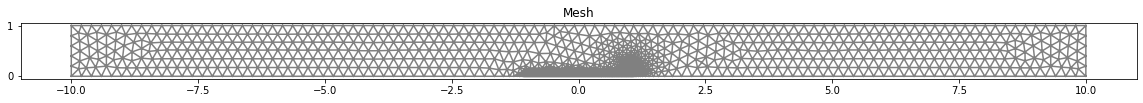

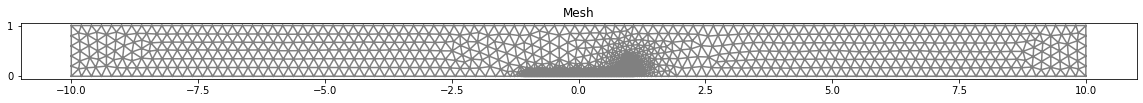

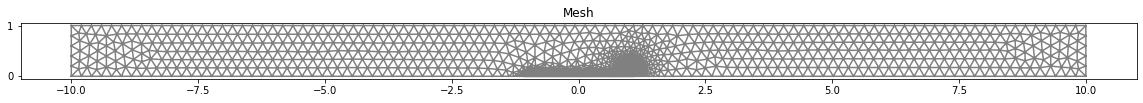

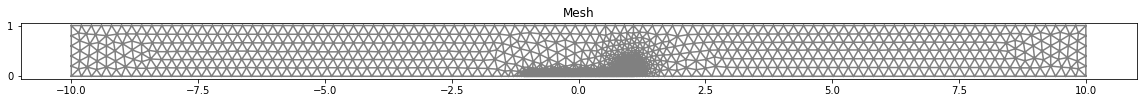

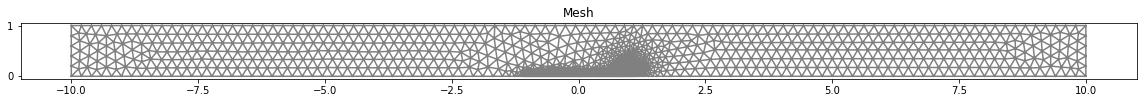

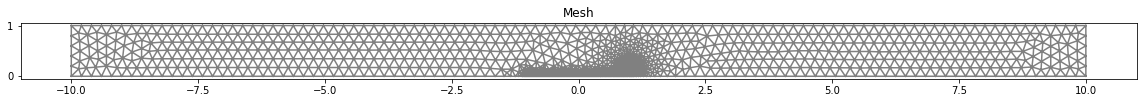

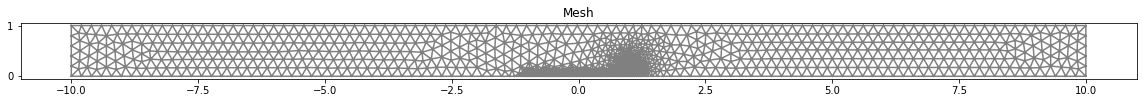

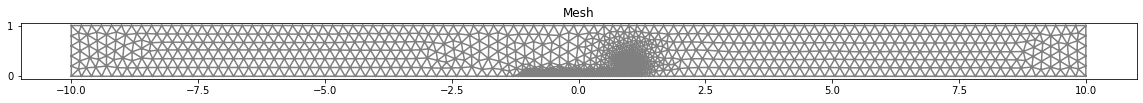

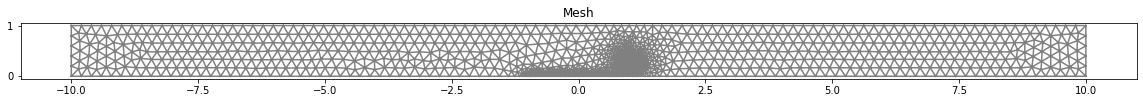

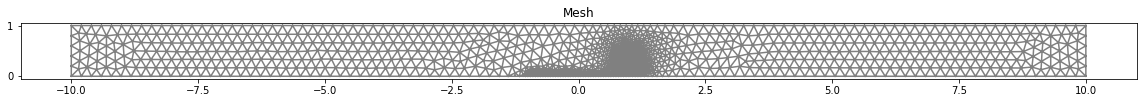

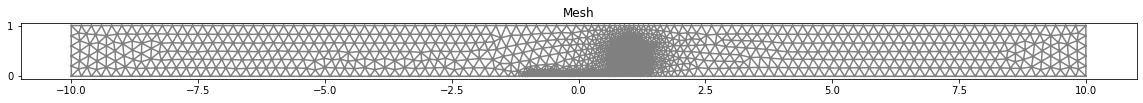

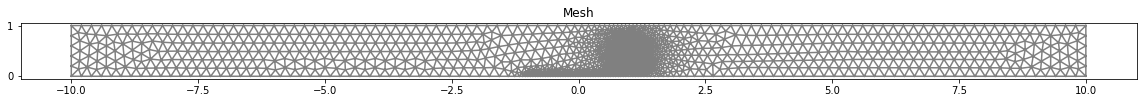

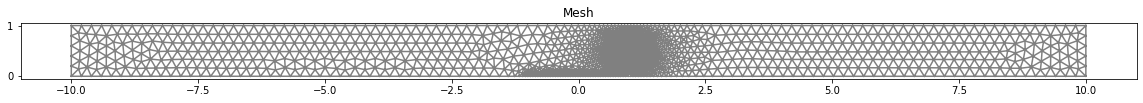

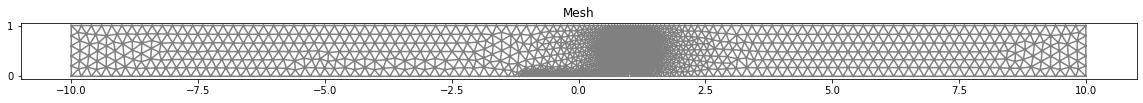

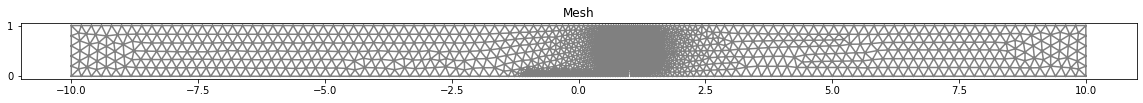

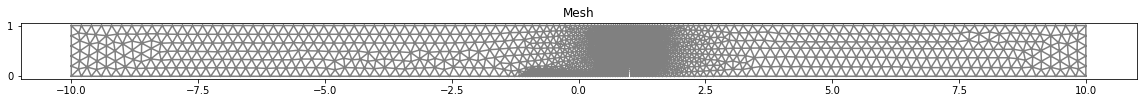

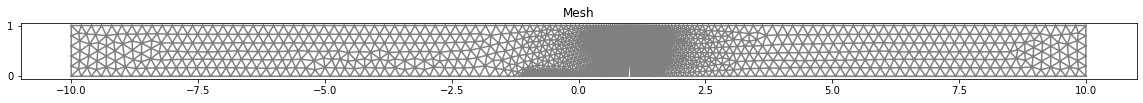

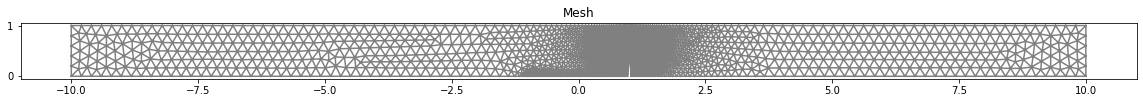

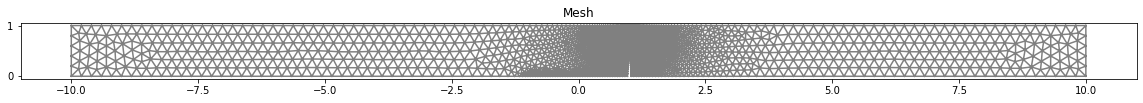

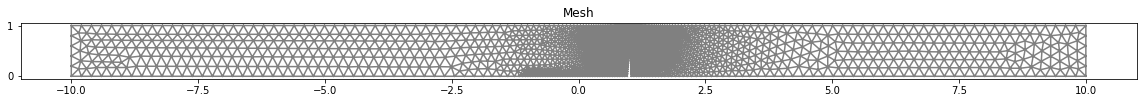

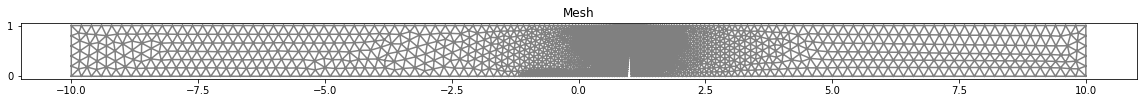

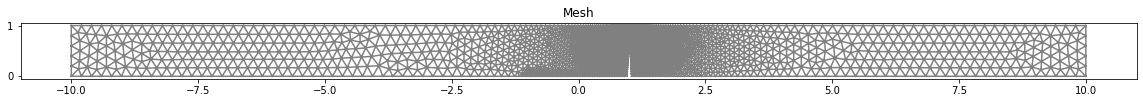

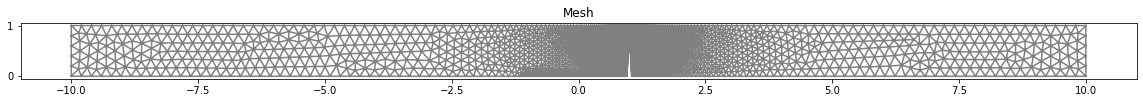

In [4]:
############# Main Loop Over Cracklengths
cindex = 0
vlambda1 = np.arange(0.05,0.1,0.01)
vlambda2 = np.arange(0.1,1,0.05)
vlambda = np.append(vlambda1,vlambda2)
Nlambda = np.shape(vlambda)[0]

while cindex < Nlambda:
    # Initialize parameters
    C = vlambda[cindex] # (m)
    deltaw = C / 20.0
    f_base = Constant((deltatau * (w-0.5*deltaw) / (Len-deltaw), 0))
####################### Mesh Generation and Function Space#####################
    # read the mesh
    mesh = Mesh()
    # XDMFFile(MPI.comm_world, "./mesh.xdmf").read(mesh)

    with XDMFFile(MPI.comm_world, "./Notched_Mesh/Notched_mesh_C_"+str(cindex)+".xdmf") as meshfile, \
            XDMFFile(MPI.comm_world, "./Notched_Mesh/Notched_facet_mesh_C_"+str(cindex)+".xdmf") as boundaryfile:
        meshfile.read(mesh)
        mvc = MeshValueCollection("size_t", mesh, mesh.topology().dim() - 1)
        print("The MeshValueCollection: ", mvc)
        boundaryfile.read(mvc, "Boundaries")
        boundaries = MeshFunction("size_t", mesh, mvc) # Mark boundaries

    print("Plotting a Notched Rectangle Mesh")
    fig = plt.figure()
    plot(mesh,title='Mesh')
    fig.set_size_inches(20, 4)
    
#################### Create Function Space and Boundary Conditions################

    order = 3
    V = VectorFunctionSpace(mesh, 'P', order)
    # Quadrilateral elements, 2nd order
    # Create test and trial functions
    u, wv = TrialFunction(V), TestFunction(V)

    #Define Boundary Conditions
    # g3-g5 are (zero) stress on boudanry 3-5
    f0 = Constant((0.0,0.0))
    tol = 1e-14 # tolerance

    # Water pressure
    p_left = Expression(('min(-(fl-rhow*x[1]),0.0)-(rhoi*(x[1]-1))','0'), degree=order, fl=fl, rhow=rho_w, rhoi=rho_i)
    p_right = Expression(('max(fl-rhow*x[1],0.0)+(rhoi*(x[1]-1))','0'), degree=order, fl=fl, rhow=rho_w, rhoi=rho_i)
    litho_left = Expression(('1-rhoi*x[1]','0'), degree=order, rhoi=1)
    litho_right = Expression(('-1+rhoi*x[1]','0'), degree=order, rhoi=1)

    boundary_conditions = {1: {'mixed': f_base},
                  2: {'mixed': f_excess+f_base},
                  3: {'Neumann_w': p_left},
                  4: {'Neumann_w': p_right},
                  5: {'mixed': f_base},
                  6: {'Neumann': f0},
                  7: {'Neumann': f0},
                  8: {'Neumann': f0}}
    # Schematic:
    #                        7
    #       ___________________________________
    #      |                                   |
    #   8  |                                   |  6
    #      |                     3  /\  4      |
    #      |_________ _____________/  \________|
    #
    #           1           2              5
    #
    # Define strain and stress
    def epsilon(u):
        return 0.5*(nabla_grad(u) + nabla_grad(u).T)
        #return sym(nabla_grad(u))

    def sigma(u):
        return ilambda * nabla_div(u) * Identity(d) + 2 * imu * epsilon(u) 

    # Redefine boundary integration measure
    ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

    # Collect Dirichlet conditions
    bcs = []
    for i in boundary_conditions:
        if 'mixed' in boundary_conditions[i]:
            bc = DirichletBC(V.sub(1), Constant(0.0), boundaries, i)
            bcs.append(bc)

    # Collect Neumann Boundary Conditions
    integrals_N = []
    for i in boundary_conditions:
        # Zero Neumann Boundary Conditions
        if ('Neumann' in boundary_conditions[i]):
            if boundary_conditions[i]['Neumann'] != 0:
                t = boundary_conditions[i]['Neumann']
                integrals_N.append(dot(t,wv)*ds(i))
        # Zero displacement in z, friction in x
        if ('mixed' in boundary_conditions[i]):
            if boundary_conditions[i]['mixed'] != 0:
                t = boundary_conditions[i]['mixed']
                integrals_N.append(dot(t,wv)*ds(i))
        # water pressure
        if ('Neumann_w' in boundary_conditions[i]):
            if boundary_conditions[i]['Neumann_w'] != 0:
                t = boundary_conditions[i]['Neumann_w']
                integrals_N.append(dot(t,wv)*ds(i))
        # lithostatic pressure
        if ('Neumann_l' in boundary_conditions[i]):
            if boundary_conditions[i]['Neumann_l'] != 0:
                t = boundary_conditions[i]['Neumann_l']
                integrals_N.append(dot(t,wv)*ds(i))
                
########################### Set up PDE and solve########################
    uh = Function(V)
    d = u.geometric_dimension()  # space dimension
    f = Constant((0,0))
    a = inner(sigma(u), epsilon(wv)) * dx
    L = dot(f,wv)*dx + sum(integrals_N)

    # Compute Solution
    solve(a == L, uh, bcs)

    # Save solution to file in vtk format
    File('Notched_Results/displacement.pvd') << uh

    W = TensorFunctionSpace(mesh, "Discontinuous Lagrange", order)
    stress = project(sigma(uh), V=W)
    File('Notched_Results/stress.pvd') << stress
    
    ######################## Displacement Correlation###################
    tol = 1E-14
    class leftwall(SubDomain):
        def inside(self, x, on_boundary):
    #        return near(x[1],0,tol) and on_boundary
            return x[0]>w-deltaw and x[0]<w and on_boundary

    mf = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
    leftwall().mark(mf, 1)

    mesh.init(2,1)
    dofs = []
    cell_to_facets = mesh.topology()(2,1)
    for cell in cells(mesh):
        facets = cell_to_facets(cell.index())
        for facet in facets:
            if mf[facet] == 1:
                dofs_ = V.dofmap().entity_closure_dofs(mesh, 1, [facet])
                for dof in dofs_:
                    dofs.append(dof)
              
    Solution=[] # coordinates and stress intensity factors
    r=[] # radius
    DCM=[] # displacement jump
    K_star=[] # stress intensity factors

    unique_dofs = np.array(list(set(dofs)), dtype=np.int32)
    uh.set_allow_extrapolation(True)
    boundary_coords = V.tabulate_dof_coordinates()[unique_dofs]
    
    for i, dof in enumerate(unique_dofs):
        # print(boundary_coords[i], uh.vector()[dof], uh.vector()[dof+1]) # check whther the points are on boundaries
        r.append(sqrt((boundary_coords[i][0]-w)**2 + (boundary_coords[i][1]-C)**2))
        DCM.append(-uh((boundary_coords[i][0],boundary_coords[i][1])) + uh((2*w-boundary_coords[i][0],boundary_coords[i][1])))
        K_star.append(sqrt(2*pi/r[i])*imu/(kappa+1)*DCM[i]) # K2 is negative
        if(dof%2==0):
            Solution.append([r[i], DCM[i][0], DCM[i][1], K_star[i][0], -K_star[i][1]])

    def takeFirst(elem):
        return elem[0]
    Solution.sort(key=takeFirst)
    
    #for i in range(np.shape(Solution)[0]):
    #    print(Solution[i])
    #for i, dof in enumerate(unique_dofs):
    #    print(Solution[i][0], Solution[i][1], Solution[i][2], Solution[i][3], Solution[i][4])
    
###########Richardson Interpolation####################
    aindex = 2
    bindex = 3
    ra = Solution[aindex][0]
    rb = Solution[bindex][0]
    K1_a = Solution[aindex][3]
    K2_a = Solution[aindex][4]
    K1_b = Solution[bindex][3]
    K2_b = Solution[bindex][4]
    K_1 = rb / (rb - ra) * (K1_a - ra/rb*K1_b)
    K_2 = rb / (rb - ra) * (K2_a - ra/rb*K2_b)
    print('when C=',C,'K1=',K_1,'K2=',K_2)
    SIF=[C, K1c, K_1, K_2]
    
    # Save the DCM data for cracklength = C
    # DCM_data = np.matrix(Solution)
    # np.savetxt('DCM_data_C_'+str(C)+'.txt', DCM_data)

    # Save the final stress intensity factor to SIF.txt
    with open('SIF_deltatau03.txt','ab') as f:
        np.savetxt(f, np.matrix(SIF), delimiter=" ")     
        
    # Go to next case
    cindex = cindex + 1

In [1]:
15609/12

1300.75